In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib

import pandas as pd
import numpy as np
import seaborn as sns
import itertools

import sys
sys.path.append('../data/tecantaloupe/')

from growth.plate_spec import PlateSpec
from growth.plate_time_course_parser import SavageLabM1000Excel
from matplotlib import pyplot as plt

import seaborn as sns
from utils import *

matplotlib.rcParams.update({'font.size': 30})

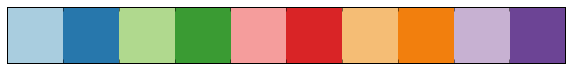

In [2]:
sns.palplot(qual_palette)

In [3]:
def prepAndNormalize(ps,timecourse,cutoffTime):
    blanked = timecourse.blank()
    smoothed = blanked.smooth()
    data = smoothed.data_for_label('abs600')
    yld = smoothed.GrowthYieldCutoff(cutoffTime,density_label='abs600')
    name2well = ps.name_to_well_mapping()

    yld = pd.DataFrame(yld, index=['yield']).T
    grouped_yld = yld.groupby(ps.well_to_name_mapping())
    mean_yield = grouped_yld.mean()
    
    normalized_yld = yld / mean_yield.loc['bw+pFE-sfGFP']
    normalized_mean_yld = normalized_yld.groupby(ps.well_to_name_mapping()).mean()
    normalized_std_yld = normalized_yld.groupby(ps.well_to_name_mapping()).std()
    return( (normalized_mean_yld,normalized_std_yld,grouped_yld) )

../data/tecantaloupe/growth/plate_time_course_parser.py:80: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  return clipped_df.convert_objects(convert_numeric=True)
/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


pval for comparison of CAF+pFE-DAB2_wt and CAF+pFE-DC351 is: 1.24E-08
pval for comparison of CAF+pFE-DAB2_wt and CAF+pFE-DD353 is: 1.60E-11
pval for comparison of CAF+pFE-DAB2_wt and CAF+pFE-DAB2+dHis1 is: 2.72E-08
pval for comparison of CAF+pFE-DAB2_wt and CAF+pFE-DAB2+dCys1 is: 2.62E-08


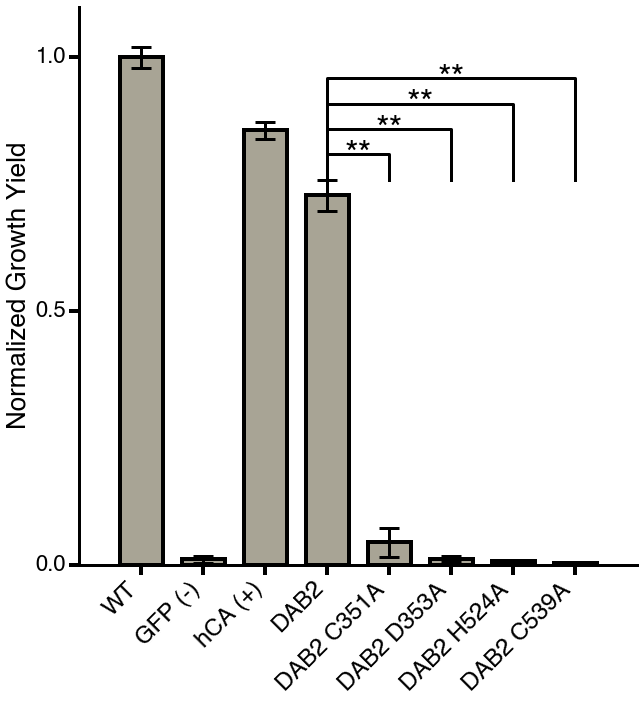

In [4]:
fig,ax = plt.subplots(figsize=(10,10))

# PlateSpec defined in CSV for easy editing
ps = PlateSpec.FromFile('../data/tecantaloupe/growth/plate_specs/2018_02_07_operon1CAFreeKnockInGrowth_metalKO_nice.csv')
parser = SavageLabM1000Excel()
timecourse = parser.ParseFromFilename('../data/tecantaloupe/growth/data/2018_02_09_CAFree_operon1_rescue_experiment_metal_KO_later.xlsx')
normalized_mean_yld,normalized_std_yld,grouped_yld=prepAndNormalize(ps,timecourse,24)

#     print(normalized_mean_yld)

ps2 = PlateSpec.FromFile('../data/tecantaloupe/growth/plate_specs/2018_03_23_operon1CAFreeKnockInGrowth_metalandproton_nice.csv')
parser2 = SavageLabM1000Excel()
timecourse2 = parser2.ParseFromFilename('../data/tecantaloupe/growth/data/2018_03_24_CAFree_DAB2_protonWire.xlsx')
normalized_mean_yld2,normalized_std_yld2,grouped_yld2=prepAndNormalize(ps2,timecourse2,24)

#     print(data)
to_plot = [
    ('bw+pFE-sfGFP', 'WT'),
    ('CAF+pFE-sfGFP', 'GFP (-)'),
    ('CAF+pFE-HCA2', 'hCA (+)'),
    ('CAF+pFE-DAB2_wt', 'DAB2'),
    ('CAF+pFE-DC351', 'DAB2 C351A'),
    ('CAF+pFE-DD353', 'DAB2 D353A'),
    ('CAF+pFE-DAB2+dHis1', 'DAB2 H524A'),
    ('CAF+pFE-DAB2+dCys1', 'DAB2 C539A'),
]

to_add=[
    'CAF+pFE-DC351',
    'CAF+pFE-DD353',
]

to_test2 = [
    ('CAF+pFE-DAB2_wt', 'CAF+pFE-DC351',3,4),
    ('CAF+pFE-DAB2_wt', 'CAF+pFE-DD353',3,5),
]
to_test = [
    ('CAF+pFE-DAB2_wt', 'CAF+pFE-DAB2+dHis1',3,6),
    ('CAF+pFE-DAB2_wt', 'CAF+pFE-DAB2+dCys1',3,7),
]

for label in to_add:
    m =normalized_mean_yld2.loc[label]
    normalized_mean_yld.ix[label]=m
    normalized_std_yld.ix[label]=normalized_std_yld2.loc[label]
#     print(normalized_mean_yld)

labels = [name for label, name in to_plot]
ylds = [normalized_mean_yld.loc[t[0]][0] for t in to_plot]
stds = [normalized_std_yld.loc[t[0]][0] for t in to_plot]

xs = np.arange(len(ylds))
plt.bar(xs, ylds, yerr=stds, color=greyish, align='center', ecolor='k', width=0.7, edgecolor='k',
        linewidth=4, capsize=10, error_kw={'capsize': 10, 'capthick': 3, 'elinewidth': 3})



i=0

for test1,test2,x1,x2 in to_test2:
    i+=1
    y=max(ylds[x1]+stds[x1],ylds[x2]+stds[x2])
    h=i/20
#     print(grouped_yld.get_group(test[0])['yield'])
    tval,pval = ttest_ind(grouped_yld2.get_group(test1)['yield'],grouped_yld2.get_group(test2)['yield'])
    pval_corrected=pval*(len(to_test)+len(to_test2))
#     print(pval)
    print('pval for comparison of %s and %s is: %.2E'%(test1,test2,pval_corrected))
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3, color='k')
    
    sig_str=''
    va=''
    if (pval_corrected<0.0005):
        sig_str='**'
        va='center'
    elif (pval_corrected<0.05):
        sig_str='*'
        va='center'
    else:
        sig_str='n.s.'
        va='bottom'
    
    plt.text((x1+x2)*.5, y+h, sig_str, ha='center', va=va, color='k',fontsize=35)

for test1,test2,x1,x2 in to_test:
    i+=1
    y=max(ylds[x1]+stds[x1],ylds[x2]+stds[x2])
    h=i/20
#     print(grouped_yld.get_group(test[0])['yield'])
    tval,pval = ttest_ind(grouped_yld.get_group(test1)['yield'],grouped_yld.get_group(test2)['yield'])
    pval_corrected=pval*(len(to_test)+len(to_test2))
#     print(pval)
    print('pval for comparison of %s and %s is: %.2E'%(test1,test2,pval_corrected))
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3, color='k')
    
    sig_str=''
    va=''
    if (pval_corrected<0.0005):
        sig_str='**'
        va='center'
    elif (pval_corrected<0.05):
        sig_str='*'
        va='center'
    else:
        sig_str='n.s.'
        va='bottom'
    
    plt.text((x1+x2)*.5, y+h, sig_str, ha='center', va=va, color='k',fontsize=35)
    

    
    

plt.ylabel('Normalized Growth Yield', fontsize=26)

plt.xticks(xs, labels, rotation=45, fontsize=24, ha='right')
plt.tick_params(axis='both', direction='out', bottom='on', left='on', top='off', right='off',
                length=10, width=4)
plt.yticks([0, 0.5, 1.0], fontsize=22)
plt.ylim(0.0, 1.1)
    # Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

#     change axis weight
ax.spines['left'].set_linewidth(3)
ax.spines['bottom'].set_linewidth(3)

plt.savefig('fig4/fig4A.eps',format='eps',bbox_inches='tight')
plt.show()

In [5]:
def getExcitationScan(filename):
    import numpy as np
    file = open(filename, 'r')
    graph = [line.split() for line in file if line[0].isdigit()]
    file.close()
    return(np.array([float(i[0]) for i in graph]),np.array([float(i[1]) for i in graph]))

In [6]:
toPlot = [
    ['Acetone_BCA_Se_001.bip','bCA (+)'],
    ['Acetone_DAB2_SEDC_Se_001.bip','Dab2'],
    ['bufferBlank_02_Se_001.bip','Buffer (-)'],
    ['bufferBlank_03_Se_001.bip','Buffer (-)'],
    ['BCA_acetone.bip','bCA (+)'],
    ['DAB2_acetone_3.bip','Dab2'],
    ['DAB2_DC_his_acetone.bip','Dab2 C351A'],
    ['DAB2_DC_strep_acetone.bip','Dab2 C351A'],
    ['DAB2_DD_strep_acetone_2.bip','Dab2 D353A'],
    ['DAB2_DD_strep_acetone.bip','Dab2 D353A'],
]

names2traces = {
    'bCA (+)': ['Acetone_BCA_Se_001.bip', 'BCA_acetone.bip'],
    'Buffer (-)': ['bufferBlank_02_Se_001.bip', 'bufferBlank_03_Se_001.bip'],
    'DAB2': ['DAB2_acetone_3.bip', 'Acetone_DAB2_SEDC_Se_001.bip'],
    'DAB2 C351A': ['DAB2_DC_his_acetone.bip', 'DAB2_DC_strep_acetone.bip'],
    'DAB2 D353A': ['DAB2_DD_strep_acetone_2.bip', 'DAB2_DD_strep_acetone.bip'],
}

names2colors = {
    'bCA (+)': qual_palette[9],
    'Buffer (-)': qual_palette[7],
    'DAB2': qual_palette[1], 
    'DAB2 C351A': qual_palette[5],
    'DAB2 D353A': qual_palette[3], 
}

nameorder = ['Buffer (-)', 'DAB2 C351A', 'DAB2 D353A', 'DAB2', 'bCA (+)']

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


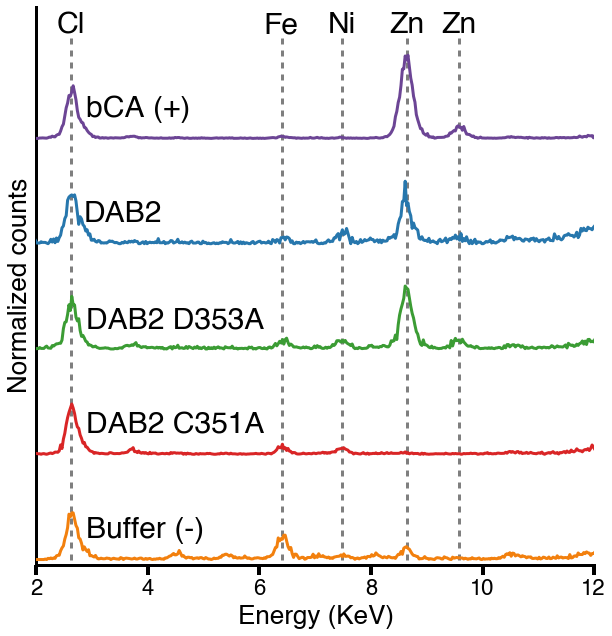

In [7]:
fig,ax = plt.subplots(figsize=(10,10), frameon=False)

fileLoc = '../data/zincBindingFilesForPaper/'
data_df = pd.DataFrame(columns=['x'],dtype='float')

for i, name in enumerate(nameorder):
    for fname in names2traces[name]:
        full_fname = fileLoc + fname
    
        x,y=getExcitationScan(full_fname)
        y=y/max(y[(x>2000) & (x<3500)])
        temp_df = pd.DataFrame(columns=['x',fname],dtype='float')
        temp_df['x'] = x
        temp_df[fname] = y
        temp_df.loc[-1] = ['name', name]
        data_df = data_df.merge(temp_df, on='x',how='outer')
    
    
data_df = data_df.set_index('x').transpose()
for column in data_df:
    if column != 'name':
        data_df[column] = data_df[column].astype(float)
        
data_df = data_df.groupby('name',axis=0).mean().transpose()[nameorder]
#     return(data_df)
x=data_df.index
for i, col in enumerate(data_df.columns):
    y = data_df[col]+i*2
    name = data_df[col].name
    c = names2colors[name]
    ax.plot(x, y, zorder=5, lw=3, color=c)
    plt.text(2900,(i*2)+0.3,col,ha='left',va='bottom')

top=len(data_df.columns)*2+0.5
plt.xlim(2000,12000)
locs,labels = plt.xticks()
ticks=[str(int(x/1000)) for x in locs]
plt.xticks(locs, ticks, fontsize=22)
plt.ylim(-0.1,top)


#     plt.vlines([2622.39,2815.6,7478.15,8638.86,9572.0],0,6,zorder=0 ,alpha=0.5)
plt.vlines([2622.39,6403.84,7478.15,8638.86,9572.0],0,top-0.5,zorder=0 ,alpha=0.5,linestyles='--',lw=3)
#     plt.text(2622.39,top-0.6,'Cl Ka1',ha='center',va='bottom')
#     plt.text(7478.15,top-0.6,'Ni Ka1',ha='center',va='bottom')
#     plt.text(8638.86,top-0.6,'Zn Ka1',ha='center',va='bottom')
#     plt.text(9572.0,top-0.6,'Zn Kb1',ha='center',va='bottom')
#     plt.text(6403.84,top-0.6,'Fe Ka1',ha='center',va='bottom')
plt.text(2622.39,top-0.6,'Cl',ha='center',va='bottom')
plt.text(7478.15,top-0.6,'Ni',ha='center',va='bottom')
plt.text(8638.86,top-0.6,'Zn',ha='center',va='bottom')
plt.text(9572.0,top-0.6,'Zn',ha='center',va='bottom')
plt.text(6403.84,top-0.6,'Fe',ha='center',va='bottom')
#     plt.legend(loc=[1.05,0.4])
plt.xlabel('Energy (KeV)')
plt.ylabel('Normalized counts')
plt.yticks([])
# plt.xticks(rotation=45)

plt.tick_params(axis='both', direction='out', bottom='on', left='on', top='off', right='off',
                length=10, width=4)
    # Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

#     change axis weight
ax.spines['left'].set_linewidth(3)
ax.spines['bottom'].set_linewidth(3)
    
plt.savefig('fig4/fig4D.eps', format='eps', bbox_inches='tight')

plt.show()

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


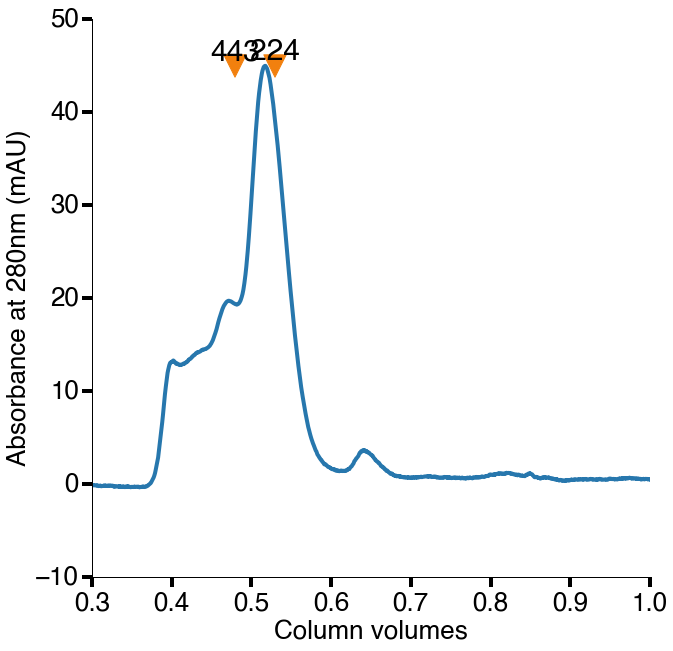

In [8]:
fig,ax = plt.subplots(figsize=(10,10))
s200=pd.read_csv('../data/DAB2-Batch5/18Sept27_DABS200/18Sept27_DAB_S200Inrease_Cleaned.csv')
cv = s200['UV 1_280_ml']/2.4
plt.plot(cv,s200['UV 1_280_mAU'],label='UV 280', color=qual_palette[1],lw=4)
#     plt.plot(s200['UV 2_485_ml'],s200['UV 2_485_mAU'],label='UV 485')
plt.xlim(0,max(cv))
plt.ylabel('Absorbance at 280nm (mAU)',fontsize=26)
plt.xlabel('Column volumes',fontsize=26)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)
plt.xlim(0.3,1)
plt.tick_params(axis='both', direction='out', bottom='on', left='on', top='off', right='off',
                length=10, width=4)
    # Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

peak=s200['UV 1_280_ml'][s200['UV 1_280_mAU']==max(s200['UV 1_280_mAU'])].iloc[0]/2.4
bX=1.15/2.4
bY=443
lX=1.27/2.4
lY=224
slope=(lY-bY)/(lX-bX)
kDa = bY+slope*(peak-bX)
peak_height = s200[s200['UV 1_280_ml']==peak*2.4]['UV 1_280_mAU'].iloc[0]
plt.scatter([bX,lX],[peak_height]*2,s = 500,marker='v',color=qual_palette[7])

plt.text(bX,peak_height,'%d'%bY,ha='center',va='bottom')
plt.text(lX,peak_height,'%d'%lY,ha='center',va='bottom')


# plt.axvline(peak,label=kDa,c='g')

# plt.axvline(bX,label=bY,c='r')
# plt.axvline(lX,label=lY,c='k')

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

# plt.ylim(-0.5,50)

# plt.legend()
    
plt.savefig('fig4/fig4PanelS3.eps',
           format='eps',bbox_inches='tight')
plt.show()

../data/tecantaloupe/growth/plate_time_course_parser.py:80: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  return clipped_df.convert_objects(convert_numeric=True)
/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


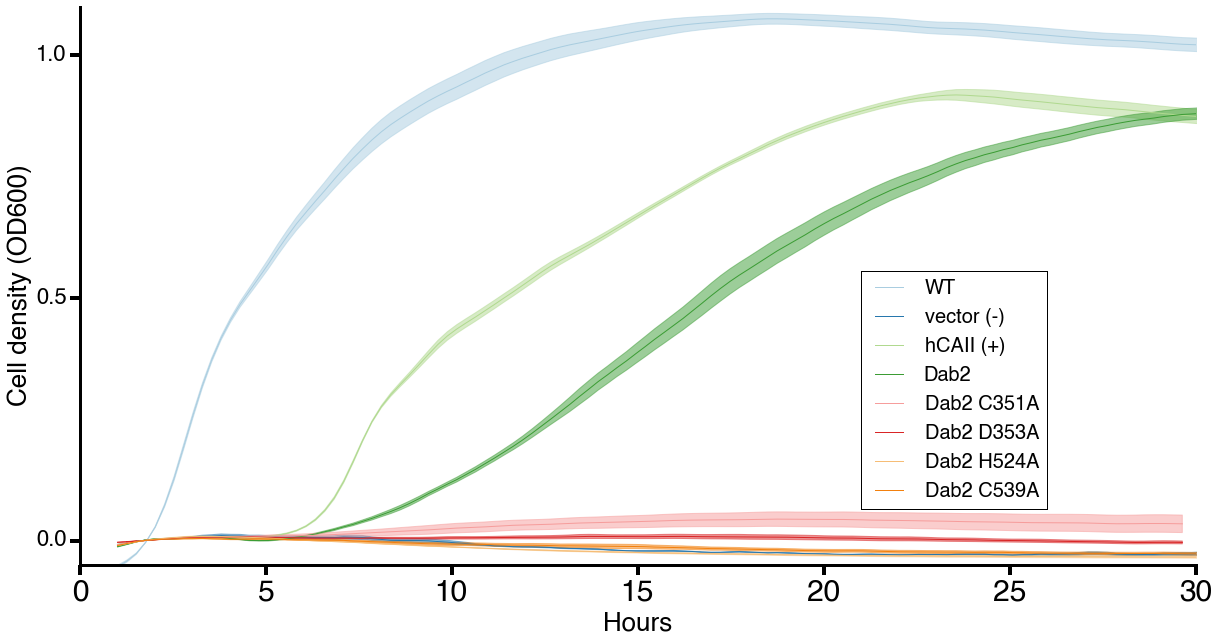

In [9]:
fig,ax = plt.subplots(figsize=(20,10))

# PlateSpec defined in CSV for easy editing
ps = PlateSpec.FromFile('../data/tecantaloupe/growth/plate_specs/2018_02_07_operon1CAFreeKnockInGrowth_metalKO_nice.csv')
parser = SavageLabM1000Excel()
timecourse1 = parser.ParseFromFilename('../data/tecantaloupe/growth/data/2018_02_09_CAFree_operon1_rescue_experiment_metal_KO_later.xlsx')
blanked1 = timecourse1.blank()
smoothed1 = blanked1.smooth()

means1 = smoothed1.mean_by_name(ps)
sems1 = smoothed1.sem_by_name(ps)

mean_OD1 = means1.data_for_label('abs600')
sems_OD1 = sems1.data_for_label('abs600')


#     print(normalized_mean_yld)

ps2 = PlateSpec.FromFile('../data/tecantaloupe/growth/plate_specs/2018_03_23_operon1CAFreeKnockInGrowth_metalandproton_nice.csv')
parser2 = SavageLabM1000Excel()
timecourse2 = parser2.ParseFromFilename('../data/tecantaloupe/growth/data/2018_03_24_CAFree_DAB2_protonWire.xlsx')
blanked2 = timecourse2.blank()
smoothed2 = blanked2.smooth()

means2 = smoothed2.mean_by_name(ps2)
sems2 = smoothed2.sem_by_name(ps2)

mean_OD2 = means2.data_for_label('abs600')
sems_OD2 = sems2.data_for_label('abs600')

mean_OD = mean_OD1.merge(mean_OD2,on='time_s',how='outer')
sems_OD = sems_OD1.merge(sems_OD2,on='time_s',how='outer')

time_h = mean_OD.time_s / (60.0*60.0)



#     print(data)
to_plot = [
    ('bw+pFE-sfGFP_x', 'WT'),
    ('CAF+pFE-sfGFP_x', 'vector (-)'),
    ('CAF+pFE-HCA2', 'hCAII (+)'),
    ('CAF+pFE-DAB2_wt_x', 'Dab2'),
    ('CAF+pFE-DC351', 'Dab2 C351A'),
    ('CAF+pFE-DD353', 'Dab2 D353A'),
    ('CAF+pFE-DAB2+dHis1', 'Dab2 H524A'),
    ('CAF+pFE-DAB2+dCys1', 'Dab2 C539A'),
]


labels = [name for label, name in to_plot]

for i, tp in enumerate(to_plot):
    c,label = tp
    color = qual_palette[i % len(qual_palette)]
    plt.fill_between(time_h, mean_OD[c] - sems_OD[c], mean_OD[c] + sems_OD[c],
                     color=color, alpha=0.5)
    plt.plot(time_h, mean_OD[c], label=label, color=color)
    
plt.xlim(0,30)

plt.ylabel('Cell density (OD600)', fontsize=26)
plt.xlabel('Hours', fontsize=26)

plt.tick_params(axis='both', direction='out', bottom='on', left='on', top='off', right='off',
                length=10, width=4)
plt.yticks([0, 0.5, 1.0], fontsize=22)
plt.ylim(-0.05, 1.1)
    # Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

#     change axis weight
ax.spines['left'].set_linewidth(3)
ax.spines['bottom'].set_linewidth(3)
plt.legend(loc=[0.7,0.1],fontsize=20)



plt.savefig('fig4/fig4S1.eps',format='eps',bbox_inches='tight')
plt.show()